In [162]:
import h5py as h5
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    validation_curve,
)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

In [163]:
np.random.seed(42)

In [164]:
# Grab extracted features and labels (TRAIN SET).
with h5.File('features_train.h5', 'r') as file:
    X_train, y_train = file['images'][:], file['labels'][:]
    classes = file['classes'][:]

### Logistic Regression

In [165]:
# Params used to find the best estimator.
params = {
    'C': [0.0001, 0.001, 0.01, 0.01, 1.0, 10.0, 100.0],
}

model = GridSearchCV(
    LogisticRegression(
        solver='lbfgs',
        multi_class='auto',
        max_iter=1000,
    ),
    param_grid=params,
    cv=3,
    n_jobs=-1, # -1: all cores
    verbose=2,
)

In [166]:
model.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:   11.5s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   18.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.01, 1.0, 10.0, 100.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [167]:
print('Best estimator is', model.best_estimator_)
print('Best score is', model.best_score_)

Best estimator is LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best score is 0.9216867469879517


### Train the best model

In [168]:
best_model = model.best_estimator_

best_model.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Cross-Validation Score

In [169]:
cvscore = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

In [170]:
f'Cross Validation Score is ~{round(np.average(cvscore), 3) * 100}%.'

'Cross Validation Score is ~92.2%.'

### Confusion matrix

In [171]:
y_train_preds = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
)

In [172]:
confusion_matrix(y_train, y_train_preds)

array([[223,  26],
       [ 13, 236]])

### Precision

In [173]:
precision_score(y_train, y_train_preds)

0.9007633587786259

### Recall

In [174]:
recall_score(y_train, y_train_preds)

0.9477911646586346

### F1-Score (harmonic mean)

In [175]:
f1_score(y_train, y_train_preds)

0.923679060665362

### Precision recall curve

In [194]:
y_scores = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=5,
    method='decision_function',
    n_jobs=-1,
)

In [195]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

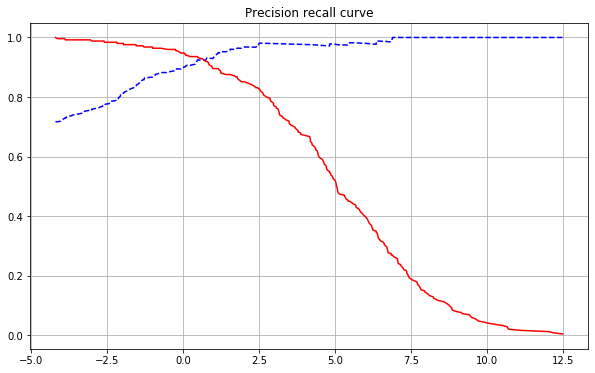

In [196]:
plt.figure(figsize=(10, 6))
plt.title('Precision recall curve')
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.grid()
plt.show()

### ROC Curve

In [197]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

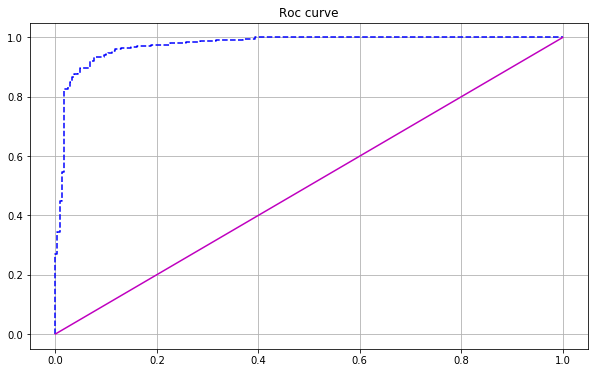

In [198]:
plt.figure(figsize=(10, 6))
plt.title('Roc curve')
plt.plot(fpr, tpr, 'b--')
plt.plot([0, 1], [0, 1], 'm-')
plt.grid()
plt.show()

### ROC-AUC Score

In [199]:
roc_auc_score(y_train, y_scores)

0.9753713649779843

### Learning curve

In [200]:
lrn_curve = learning_curve(
    best_model,
    X_train,
    y_train,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
)

In [201]:
train_sizes_abs, train_scores, val_scores = lrn_curve

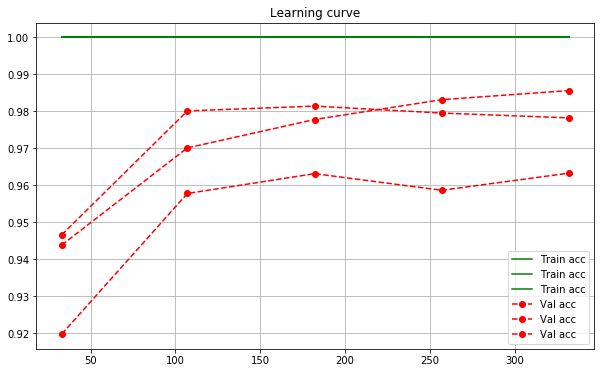

In [202]:
plt.figure(figsize=(10, 6))
plt.title('Learning curve')
plt.plot(train_sizes_abs, train_scores, 'g-', label='Train acc')
plt.plot(train_sizes_abs, val_scores, 'ro--', label='Val acc')
plt.legend(loc='best')
plt.grid()
plt.show()